In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats
import numpy as np

## Support Vector Machines

Support Vector Machines are supervised algorithms that can be used for both classification and regression.

Classification with support vector machines used **discriminative classification**, instead of modeling each class(as we do with *generative classification*), we find a line or curve or manifold that divides the classes.

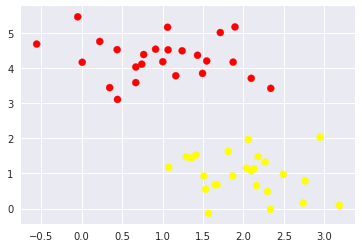

In [2]:
from sklearn.datasets.samples_generator import make_blobs

#blobs are clusters of points

X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

For data like this, we could easily draw a linear line that separates the data, but we can also see that there many lines that will perfectly seperate the data!

In [3]:
np.linspace?

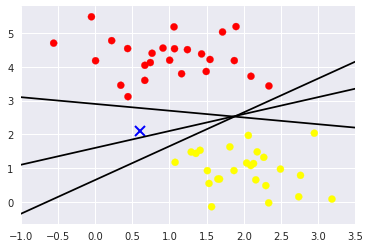

In [4]:
#create 50 evenly spaced points from -1 to 3.5
xfit = np.linspace(-1, 3.5) 

#plot our blobs of points
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

#add an unclassified X point
plt.plot([0.6], [2.1], 'x', color='blue', markeredgewidth=2, markersize=10)

#plot 3 different lines with different slopes(m) and intercepts(b)
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Our *X* point will be classified as a different group depending on which line we choose.

### Maximing the Margin

What an SVM does is instead of drawing a zero-width line, we draw a line with a margin a width up to the nearest point.

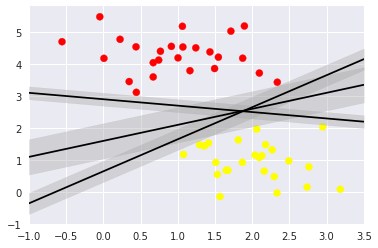

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

We want to find choose the line with the largest margin. Support Vector Machines are an example of a **maximum margin** estimator.

### Fitting an SVM

For fitting support vecotr machines a s classifier, Scikit-Learn provides the *Support Vector Classifier* as `SVC`.

In [6]:
from sklearn.svm import SVC # "Support vector classifier"

model = SVC(kernel='linear', C=1E10) 
#trained with a linear kernel and a large C value to be explained later
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [7]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, edgecolors='black')
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

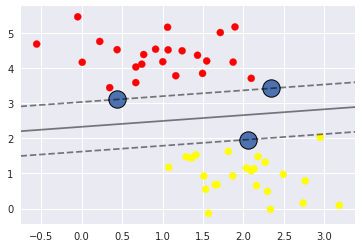

In [8]:
fig, ax1 = plt.subplots()
ax1.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model, ax=ax1);

Center Line: line that maximizes the margin between the two sets of points.
Dashed Lines: The margins, they just touch a few of our data points.

**Support Vectors:** these are the points that just touch the margin, indicated with blue circles. These give the algorithm it's names and are stored in the `support_vectors_` attribute of the classifier.

The key to the algorithm is that only the position of the support vectors matter, any points beyond them do not contribute to the loss function.

Below we see that for 60 points from the dataset or 120 points of the dataset, the fit is the same because the none of the additional points crossed the margin.

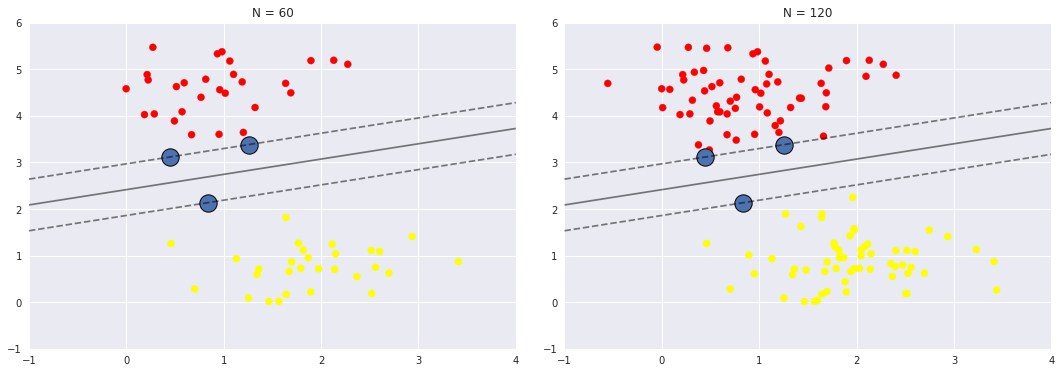

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

### Beyond linear boundaries: Kernel SVM

Sometimes a linear fit will not work for the data. When this occurs we can use kernels to project our data and find a better fit. 

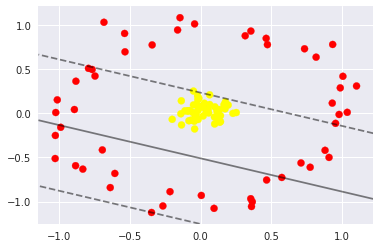

In [10]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

A simple projection we might use is to compute a **radial basis function** centered on the middle grouping of points.

In [11]:
r = np.exp(-(X ** 2).sum(1))

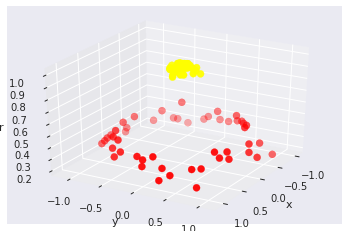

In [12]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

plot_3D();

When we use this bias function to project our data into a higher dimension, it becomes obvious that there is a plane that can be found to separate the data.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results.

**How might we choose the best basis function?**

One strategy is to compute a basis function centered at every point in the dataset, and let the SVM algorithm sift through the results. 

This type of basis function transformation is known as a **kernel transformation**, as it is based on a similarity relationship (or kernel) between each pair of points.

This method become computational insensitive as our data grows.

However we can use the **kernel trick** to fit on kernel-transformed data implicitly, without ever buildiung the full $N$-dimensional representation.

The **kernel trick** works by computing the inner products between the images of all pairs of data in the feature space.

Of course this is built into the `SVC` from Scikit-Learn, so we just need to change the kernel type.

In [13]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

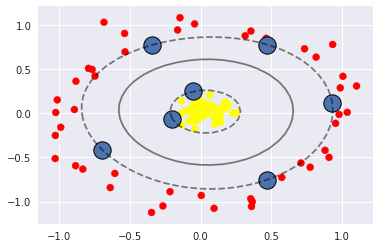

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

### Tuning the SVM: Softening Margins

So far, we've only seen data that is very neatly separated, but what about fitting the data below?

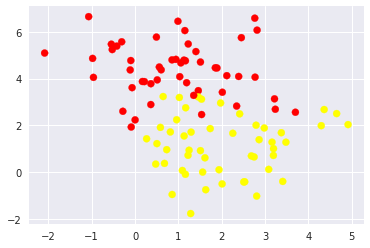

In [15]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

THis is where the $C$ parameter comes into play. It allows us to soften the marigin, allowing some points to creep in, resulting in a better fit. 

We tune $C$ to control hardness of the margin 

For a very large $C$, the margin is hard, and points cannot lie in it. 

For smaller $C$, the margin is softer, and can grow to encompass some points.

Below we have a "hard" margin on the left and a "soft" margin on the right. 

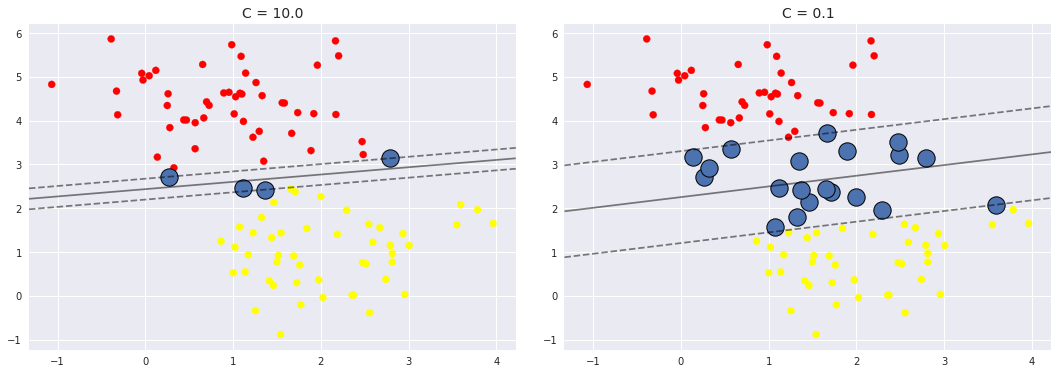

In [16]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

### Example: Face Recognition

Let's try and recognize some faces, using data!

In [17]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot some faces!

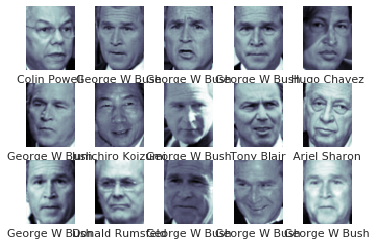

In [18]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Each image contains [62×47] or nearly 3,000 pixels.

We could use each pixel value as a feature, but it is often more offective to extract more meaningful features using a preprocessor, such as **PCA** (principal component analysis.

We can extract 150 fundamental components to feed into our support vector machine classifier. We can do this most by packaging the preprocessor and the classifier into a single pipeline using Scikit-Learn;

In [20]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(svd_solver='randomized', n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [23]:
#split our data

from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

We can use grid search cross-validation to explore combination of parameters. $C$ controlls the margin hardness and $\text{gamma}$ controls the size of radial basis function kernel;

In [25]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 3s, sys: 1.01 s, total: 1min 4s
Wall time: 36.1 s
{'svc__C': 10, 'svc__gamma': 0.001}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

In [26]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

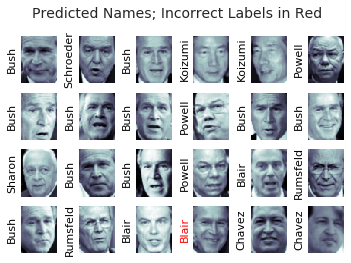

In [28]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

So, we only got one wrong, it mislabled Bush's face as Blair. 

We can use the classification report to check the recovery statistics by label and the confusion matrix to see which labels were misidentified for which.

In [29]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.73      0.69        15
     Colin Powell       0.80      0.87      0.83        68
  Donald Rumsfeld       0.74      0.84      0.79        31
    George W Bush       0.92      0.83      0.88       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.95      0.90        42

      avg / total       0.86      0.85      0.85       337



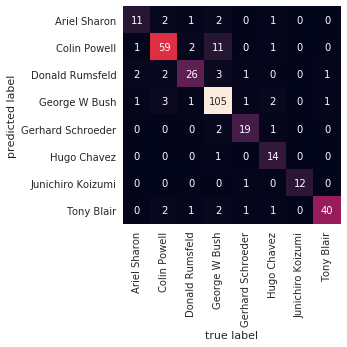

In [30]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.

### Summary

Advatages of SVM;
+ Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
+ Once the model is trained, the prediction phase is very fast.
+ Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
+ Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

Disadvantages of SVM;
+ The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
+ The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
+ The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the probability parameter of SVC), but this extra estimation is costly.

### When to use?

You want to turn to SVMs only once other simpler, faster and less tuning-intensive methods are insufficient. If you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.